## [Mestrado] 7. Experimentos com autoencoder LSTM usando 50% instâncias simuladas

### Carregamento e tratamento dos dados **simulados e reais** para experimentação:

In [1]:
# Artifício para alcular tempo total do notebook Jupyter
from datetime import datetime 
start_time = datetime.now()

In [2]:
# Experimentos para defesa de mestrado (autoencoder com lstm)
# Carregamento e tratamento dos dados simulados
%matplotlib inline
import pandas as pd
import numpy as np
import logging
import warnings
import tensorflow as tf
from math import ceil
from time import time
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore')

data_path = Path('./', 'data')
random_state = 1
np.random.seed(random_state)
tf.random.set_seed(random_state)
events_names = {0: 'Normal',
                1: 'Aumento Abrupto de BSW',
                2: 'Fechamento Espúrio de DHSV',
                3: 'Intermitência Severa',
                4: 'Instabilidade de Fluxo',
                5: 'Perda Rápida de Produtividade',
                6: 'Restrição Rápida em CKP',
                7: 'Incrustação em CKP',
                8: 'Hidrato em Linha de Produção'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # Nas observações = segundos
min_normal_period_size = 20*60  # Nas observações = segundos
split_range = 0.6               # Porcentagem de separação entre treino/teste
max_samples_per_period = 15     # limitação por 'segurança'
max_nan_percent = 0.1           # Para seleção de variáveis úteis
std_vars_min = 0.01             # Para seleção de variáveis úteis
disable_progressbar = True      # Para menos saídas no notebook

def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    """Gerador de lista contendo número da classe e caminho do arquivo de acordo com a fonte da instância."""    
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path
                        
                    
def load_instance(instance_path):
    """Função que carrega cada instância individualmente"""
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), \
            f'Colunas inválidas no arquivo {str(instance_path)}: {str(df.columns.tolist())}'
        return df
    except Exception as e:
        raise Exception(f'Erro ao ler arquivo {instance_path}: {e}')
        
def extract_samples(df, class_code):
    # Obtém os rótulos das observações e seu conjunto inequívoco
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Descarta os rótulos das observações e substitui todos os nan por 0
    # (requisito da biblioteca tsfresh)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Inicializa objetos que serão retornados
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Descubre o número máximo de amostras em períodos normais, transitórios e em regime
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Define o número inicial de amostras para o período normal
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Define o número máximo de amostras por período transitório
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição
        # no início do período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Define o número máximo de amostras no período de regime
    if class_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou fim do período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Descubre o número adequado de amostras em períodos normais, transitórios e em regime
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    
    # Extrai amostras do período normal para treinamento e teste
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Define a etapa correta e extrai amostras
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extrai amostras para treinamento
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extrai amostras para teste
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extrai amostras do período transitório (se existir) para teste
    if (num_transient_samples) > 0:    
        # Define a etapa correta e extrai amostras
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição no início deste período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extrai amostras
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extrai amostras do período em regime (se existir) para teste
    if (num_in_regime_samples) > 0:     
        # Define a etapa correta e extrai amostras
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou no final deste período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extrai amostras
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test

In [3]:
# Gets all simulated instances but maintains only those with any type of undesirable event
simulated_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=False,
                                                       simulated=True, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
simulated_instances = simulated_instances.loc[simulated_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

X_train_simuladas_unificado = pd.DataFrame()
y_train_simuladas_unificado = np.array([])
X_test_simuladas_unificado = pd.DataFrame()    
y_test_simuladas_unificado = np.array([])

# For each instance with any type of undesirable event
ignored_instances = 0
used_instances = 0

# Loop por todas as instâncias para capturar as observações
for i, row in simulated_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    #print(f'Instância {i+1}: {instance_path}')
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        #print(f'\tignorado porque normal_period_size é insuficiente para treinamento ({normal_period_size})\n')
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # As observações normais com label 1 e as anomalias com label -1
    y_train[y_train!=normal_class_code] = '-1'
    y_train[y_train==normal_class_code] = '1'
    y_test[y_test!=normal_class_code] = '-1'
    y_test[y_test==normal_class_code] = '1'
    
    """
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    """
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[vars] = scaler.fit_transform(df_samples_train[vars]).astype('float32')
    df_samples_test[vars] = scaler.transform(df_samples_test[vars]).astype('float32')
    
    # Remove a coluna timestamp (não é usada como entrada nos classificadores)
    df_samples_train = df_samples_train.drop('timestamp', 1)
    df_samples_test = df_samples_test.drop('timestamp', 1)
    
    # Rearranja o dataframe df_samples_train para que as variáveis estejam em linha
    df_samples_train_ajustado = (
        df_samples_train.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_train.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    # Rearranja o dataframe df_samples_test para que as variáveis estejam em linha
    df_samples_test_ajustado = (
        df_samples_test.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_test.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    X_train = df_samples_train_ajustado
    X_test = df_samples_test_ajustado
    
    # Agrupa as observacoes de cada instancia em dataframe unificado
    X_train_simuladas_unificado = X_train_simuladas_unificado.append(df_samples_train_ajustado)
    y_train_simuladas_unificado = np.concatenate((y_train_simuladas_unificado, y_train), axis=None)
    X_test_simuladas_unificado = X_test_simuladas_unificado.append(df_samples_test_ajustado)     
    y_test_simuladas_unificado = np.concatenate((y_test_simuladas_unificado, y_test), axis=None)
    

# Ajustes para completar valores faltantes com zero e remover os multiindexes criados
X_train_simuladas_unificado = X_train_simuladas_unificado.replace(np.nan, 0)
X_test_simuladas_unificado = X_test_simuladas_unificado.replace(np.nan, 0)

X_train_simuladas_unificado.drop('id',  axis='columns', inplace=True)
X_test_simuladas_unificado.drop('id',  axis='columns', inplace=True)

X_train_simuladas_unificado = X_train_simuladas_unificado.droplevel(0, axis=1)
X_test_simuladas_unificado = X_test_simuladas_unificado.droplevel(0, axis=1)

X_train_simuladas_unificado = X_train_simuladas_unificado.T.reset_index(drop=True).T
X_test_simuladas_unificado = X_test_simuladas_unificado.T.reset_index(drop=True).T

X_train_simuladas_unificado.reset_index(inplace=True, drop=True)
X_test_simuladas_unificado.reset_index(inplace=True, drop=True)

# Reshape dos dados para formato de entrada da rede LSTM
# que é um array 3D no formato (observações, timesteps, features)
X_train_simuladas_unificado = X_train_simuladas_unificado.values.reshape(X_train_simuladas_unificado.shape[0], 180, X_train_simuladas_unificado.shape[1] // 180, order='F')
X_test_simuladas_unificado = X_test_simuladas_unificado.values.reshape(X_test_simuladas_unificado.shape[0], 180, X_test_simuladas_unificado.shape[1] // 180, order='F')

# Shuffle no dataset para misturar as classes de anomalias
X_train_simuladas_unificado, y_train_simuladas_unificado = shuffle(X_train_simuladas_unificado, y_train_simuladas_unificado, random_state=random_state)
X_test_simuladas_unificado, y_test_simuladas_unificado = shuffle(X_test_simuladas_unificado, y_test_simuladas_unificado, random_state=random_state)

In [4]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)


X_train_reais_unificado = pd.DataFrame()
y_train_reais_unificado = np.array([])
X_test_reais_unificado = pd.DataFrame()    
y_test_reais_unificado = np.array([])

# For each instance with any type of undesirable event
ignored_instances = 0
used_instances = 0

# Loop por todas as instâncias para capturar as observações
for i, row in real_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    #print(f'Instância {i+1}: {instance_path}')
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        #print(f'\tignorado porque normal_period_size é insuficiente para treinamento ({normal_period_size})\n')
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # As observações normais com label 1 e as anomalias com label -1
    y_train[y_train!=normal_class_code] = '-1'
    y_train[y_train==normal_class_code] = '1'
    y_test[y_test!=normal_class_code] = '-1'
    y_test[y_test==normal_class_code] = '1'
    
    """
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    """
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[vars] = scaler.fit_transform(df_samples_train[vars]).astype('float32')
    df_samples_test[vars] = scaler.transform(df_samples_test[vars]).astype('float32')
    
    # Remove a coluna timestamp (não é usada como entrada nos classificadores)
    df_samples_train = df_samples_train.drop('timestamp', 1)
    df_samples_test = df_samples_test.drop('timestamp', 1)
    
    # Rearranja o dataframe df_samples_train para que as variáveis estejam em linha
    df_samples_train_ajustado = (
        df_samples_train.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_train.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    # Rearranja o dataframe df_samples_test para que as variáveis estejam em linha
    df_samples_test_ajustado = (
        df_samples_test.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_test.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    X_train = df_samples_train_ajustado
    X_test = df_samples_test_ajustado
    
    # Agrupa as observacoes de cada instancia em dataframe unificado
    X_train_reais_unificado = X_train_reais_unificado.append(df_samples_train_ajustado)
    y_train_reais_unificado = np.concatenate((y_train_reais_unificado, y_train), axis=None)
    X_test_reais_unificado = X_test_reais_unificado.append(df_samples_test_ajustado)     
    y_test_reais_unificado = np.concatenate((y_test_reais_unificado, y_test), axis=None)
    

# Ajustes para completar valores faltantes com zero e remover os multiindexes criados
X_train_reais_unificado = X_train_reais_unificado.replace(np.nan, 0)
X_test_reais_unificado = X_test_reais_unificado.replace(np.nan, 0)

X_train_reais_unificado.drop('id',  axis='columns', inplace=True)
X_test_reais_unificado.drop('id',  axis='columns', inplace=True)

X_train_reais_unificado = X_train_reais_unificado.droplevel(0, axis=1)
X_test_reais_unificado = X_test_reais_unificado.droplevel(0, axis=1)

X_train_reais_unificado = X_train_reais_unificado.T.reset_index(drop=True).T
X_test_reais_unificado = X_test_reais_unificado.T.reset_index(drop=True).T

X_train_reais_unificado.reset_index(inplace=True, drop=True)
X_test_reais_unificado.reset_index(inplace=True, drop=True)

# Reshape dos dados para formato de entrada da rede LSTM
# que é um array 3D no formato (observações, timesteps, features)
X_train_reais_unificado = X_train_reais_unificado.values.reshape(X_train_reais_unificado.shape[0], 180, X_train_reais_unificado.shape[1] // 180, order='F')
X_test_reais_unificado = X_test_reais_unificado.values.reshape(X_test_reais_unificado.shape[0], 180, X_test_reais_unificado.shape[1] // 180, order='F')

# Shuffle no dataset para misturar as classes de anomalias
X_train_reais_unificado, y_train_reais_unificado = shuffle(X_train_reais_unificado, y_train_reais_unificado, random_state=random_state)
X_test_reais_unificado, y_test_reais_unificado = shuffle(X_test_reais_unificado, y_test_reais_unificado, random_state=random_state)

### Aplicação do classificador com diversas combinações de parâmetros em 50% das instâncias simuladas

In [5]:
# Obtem 50% das instâncias simuladas para calibração
X_train_simuladas_unificado_50 = X_train_simuladas_unificado[:ceil(0.5*len(X_train_simuladas_unificado)), :, :]
X_test_simuladas_unificado_50 = X_test_simuladas_unificado[:ceil(0.5*len(X_test_simuladas_unificado)), :, :]
y_train_simuladas_unificado_50 = y_test_simuladas_unificado[:ceil(0.5*len(X_test_simuladas_unificado))]
y_test_simuladas_unificado_50 = y_test_simuladas_unificado[:ceil(0.5*len(X_test_simuladas_unificado))]

PARÂMETROS: {'batch_size': 32, 'dropout': 0, 'learning_rate': 0.0001, 'lstm_units': 32}


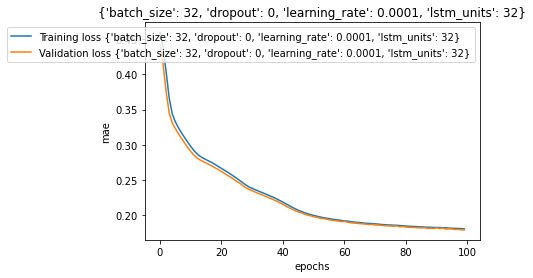

mean_trainMAE: 0.1797967553138733


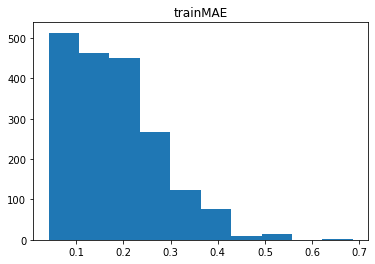

max_trainMAE: 	 0.6860911846160889


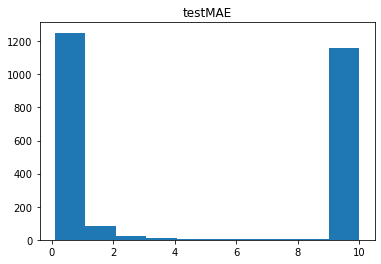

F1: 	 0.8685446009389672

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0, 'learning_rate': 0.0001, 'lstm_units': 64}


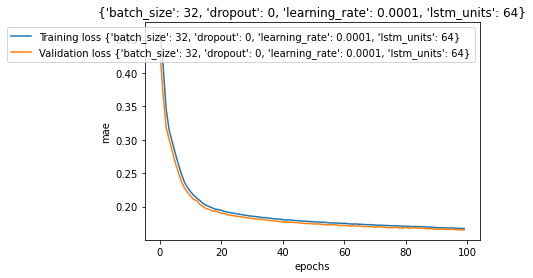

mean_trainMAE: 0.1666003167629242


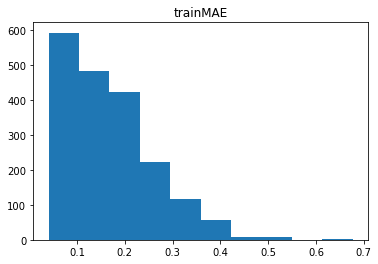

max_trainMAE: 	 0.6774601936340332


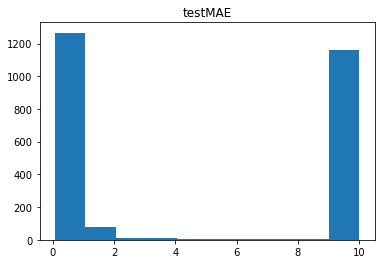

F1: 	 0.8767605633802817

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0, 'learning_rate': 0.001, 'lstm_units': 32}


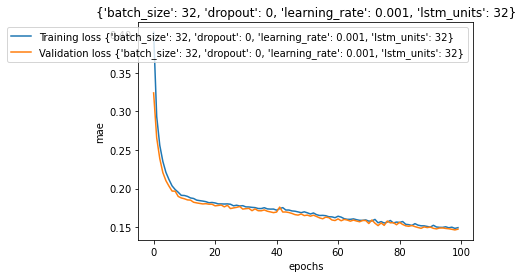

mean_trainMAE: 0.14775559306144714


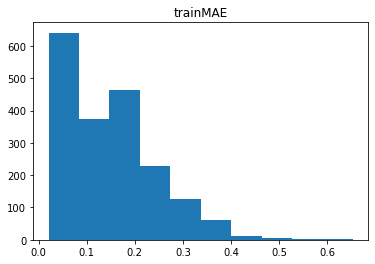

max_trainMAE: 	 0.6530506610870361


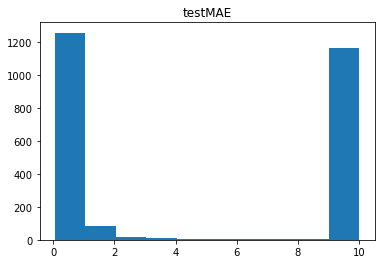

F1: 	 0.8720657276995305

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0, 'learning_rate': 0.001, 'lstm_units': 64}


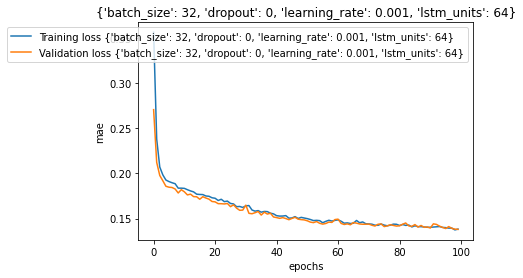

mean_trainMAE: 0.1376773566007614


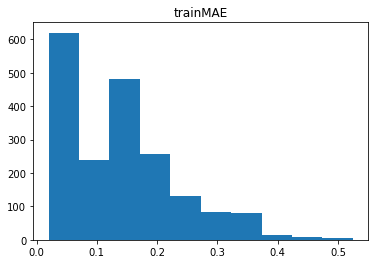

max_trainMAE: 	 0.5244910717010498


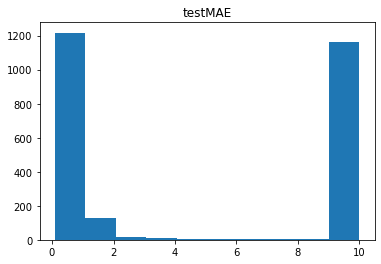

F1: 	 0.8192488262910798

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0, 'learning_rate': 0.01, 'lstm_units': 32}


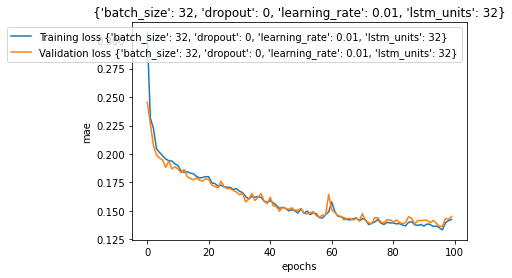

mean_trainMAE: 0.14382238686084747


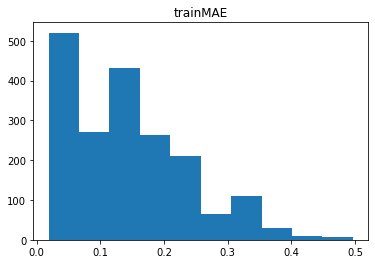

max_trainMAE: 	 0.49652576446533203


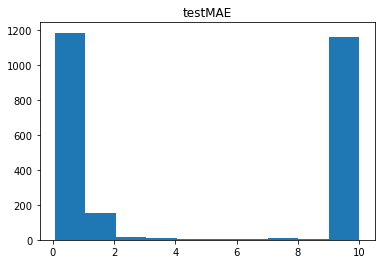

F1: 	 0.80320813771518

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0, 'learning_rate': 0.01, 'lstm_units': 64}


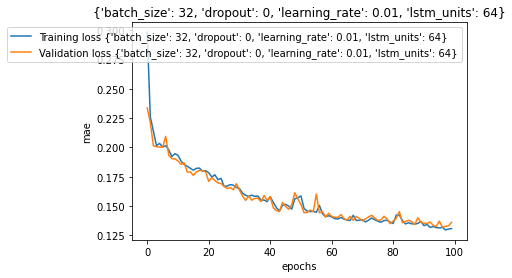

mean_trainMAE: 0.13444450497627258


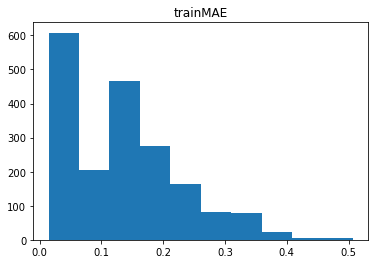

max_trainMAE: 	 0.5070446729660034


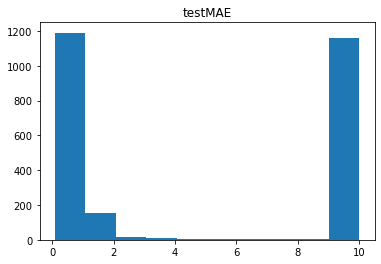

F1: 	 0.8055555555555556

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.1, 'learning_rate': 0.0001, 'lstm_units': 32}


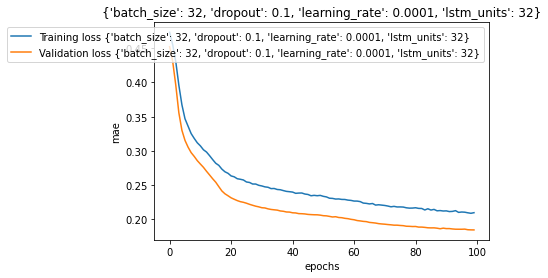

mean_trainMAE: 0.18572790920734406


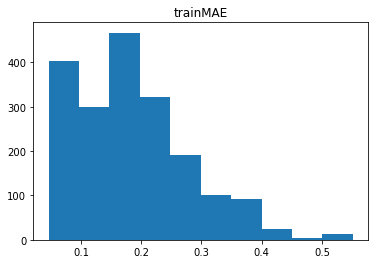

max_trainMAE: 	 0.5513300895690918


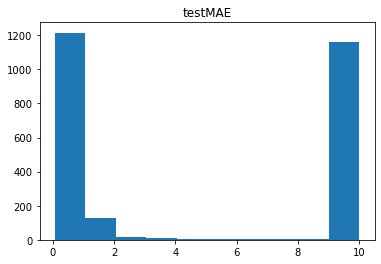

F1: 	 0.8110328638497653

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.1, 'learning_rate': 0.0001, 'lstm_units': 64}


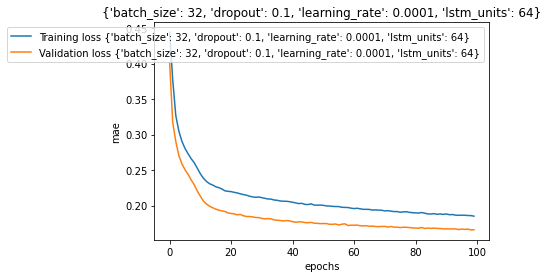

mean_trainMAE: 0.16802409291267395


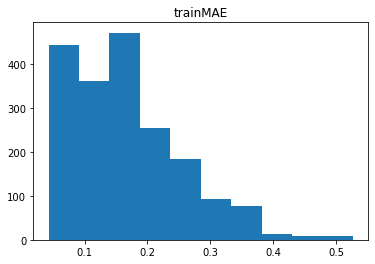

max_trainMAE: 	 0.526633620262146


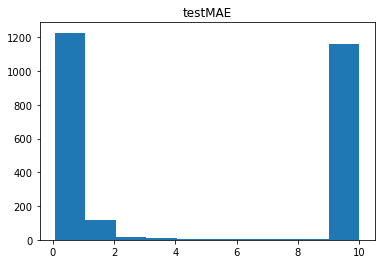

F1: 	 0.8223787167449139

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.1, 'learning_rate': 0.001, 'lstm_units': 32}


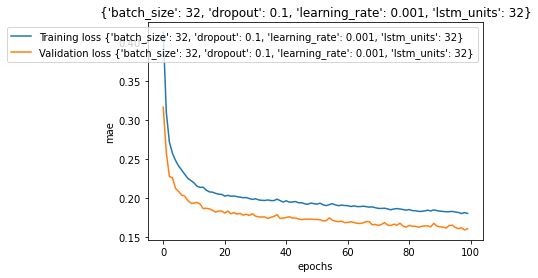

mean_trainMAE: 0.1621962934732437


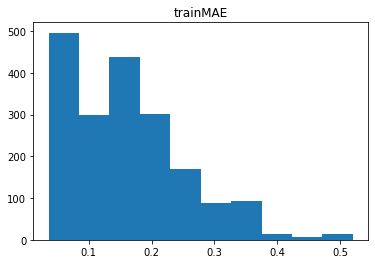

max_trainMAE: 	 0.5202125906944275


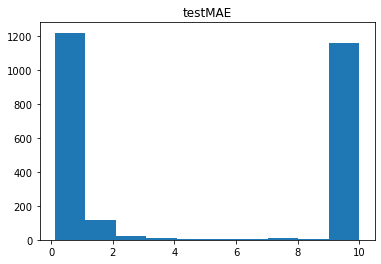

F1: 	 0.7961658841940531

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.1, 'learning_rate': 0.001, 'lstm_units': 64}


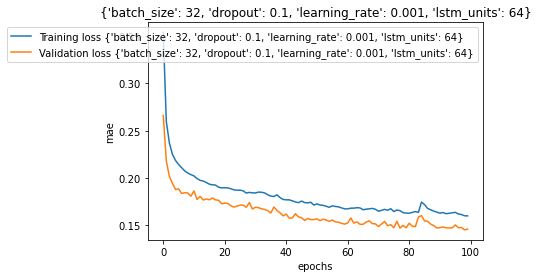

mean_trainMAE: 0.1449897140264511


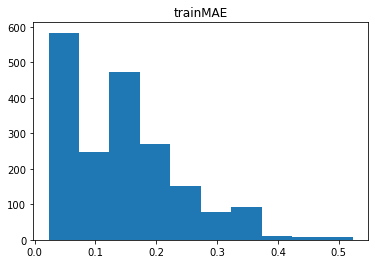

max_trainMAE: 	 0.5232994556427002


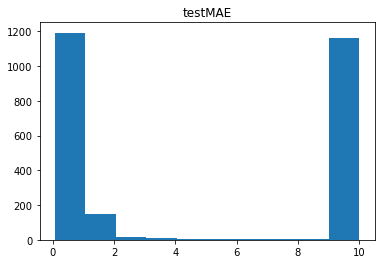

F1: 	 0.814945226917058

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.1, 'learning_rate': 0.01, 'lstm_units': 32}


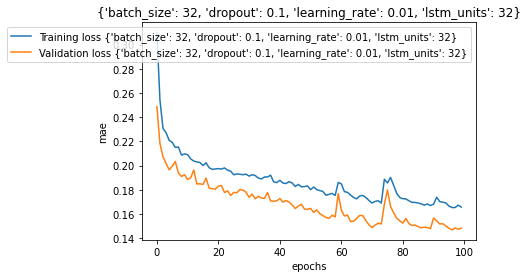

mean_trainMAE: 0.14800256490707397


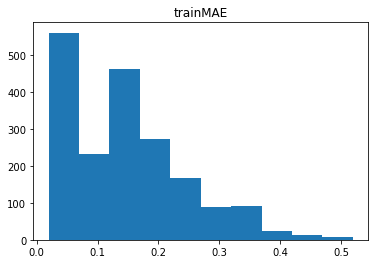

max_trainMAE: 	 0.519234836101532


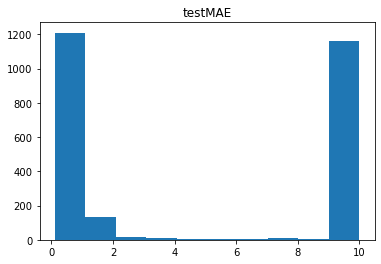

F1: 	 0.7906885758998435

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.1, 'learning_rate': 0.01, 'lstm_units': 64}


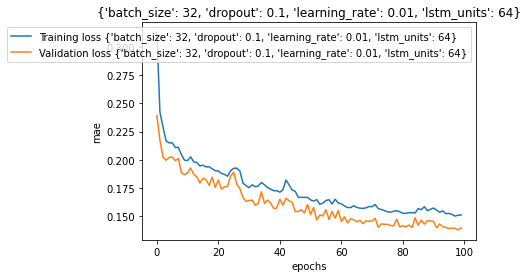

mean_trainMAE: 0.1387937068939209


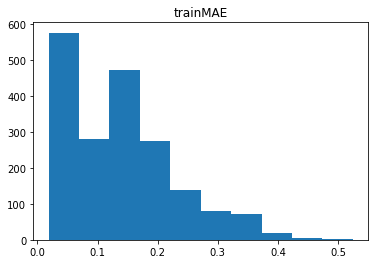

max_trainMAE: 	 0.5247334241867065


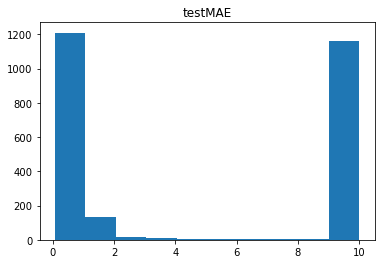

F1: 	 0.8180751173708921

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.0001, 'lstm_units': 32}


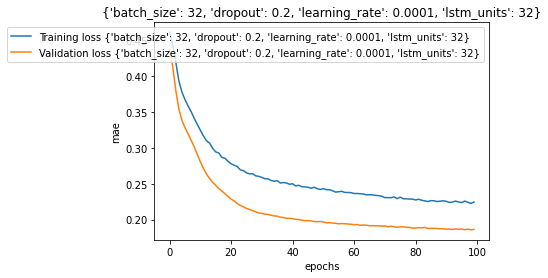

mean_trainMAE: 0.18771357834339142


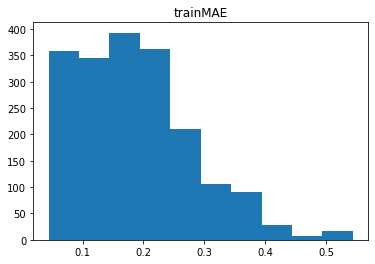

max_trainMAE: 	 0.544275164604187


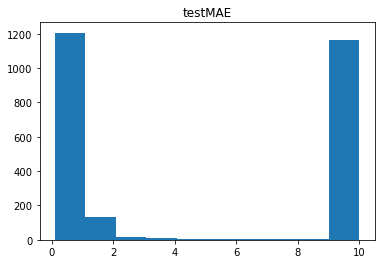

F1: 	 0.8125978090766823

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.0001, 'lstm_units': 64}


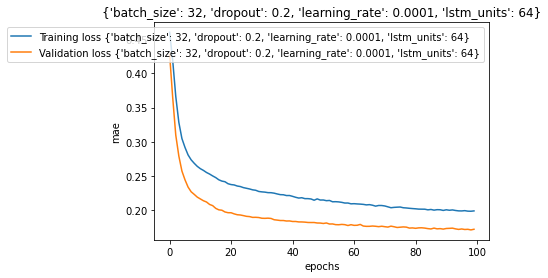

mean_trainMAE: 0.17331178486347198


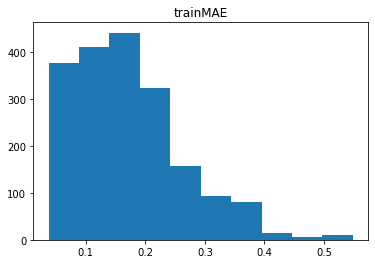

max_trainMAE: 	 0.5482980012893677


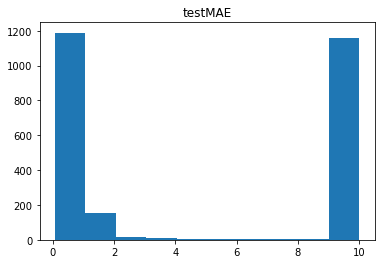

F1: 	 0.8258998435054773

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'lstm_units': 32}


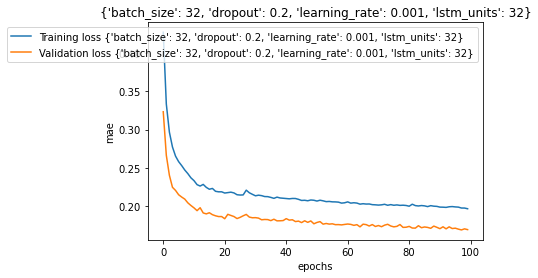

mean_trainMAE: 0.17067298293113708


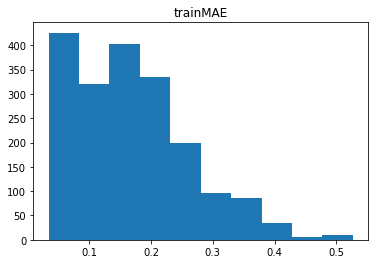

max_trainMAE: 	 0.5266979336738586


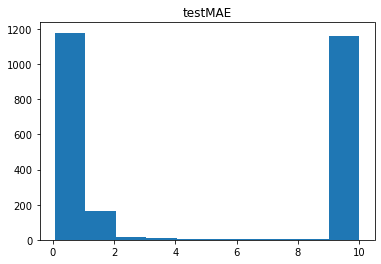

F1: 	 0.8004694835680752

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'lstm_units': 64}


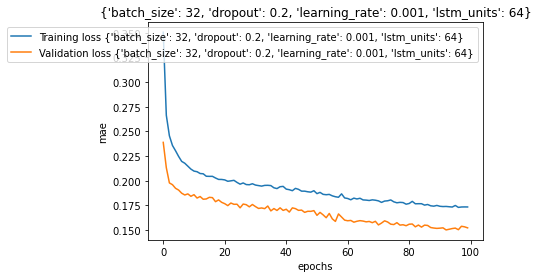

mean_trainMAE: 0.1522272825241089


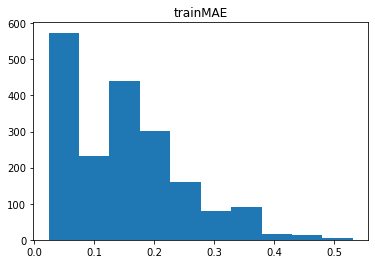

max_trainMAE: 	 0.5309522747993469


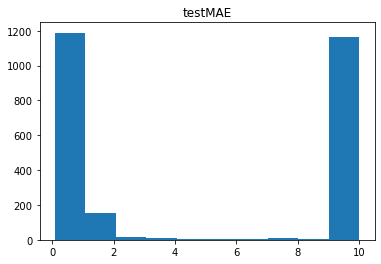

F1: 	 0.8125978090766823

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.01, 'lstm_units': 32}


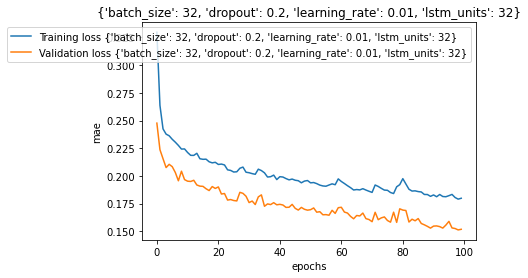

mean_trainMAE: 0.15281808376312256


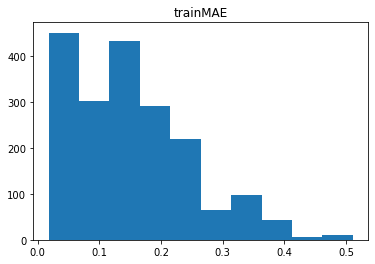

max_trainMAE: 	 0.511279284954071


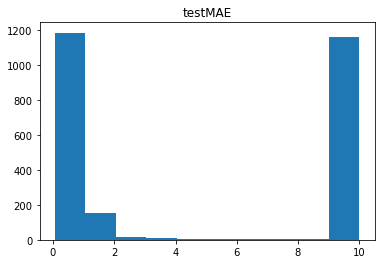

F1: 	 0.7902973395931142

#################################################################

PARÂMETROS: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.01, 'lstm_units': 64}


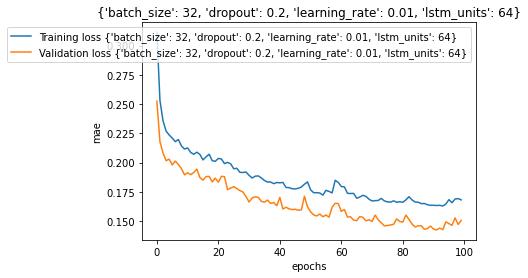

mean_trainMAE: 0.1505558341741562


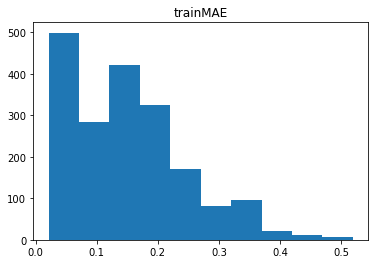

max_trainMAE: 	 0.5193037390708923


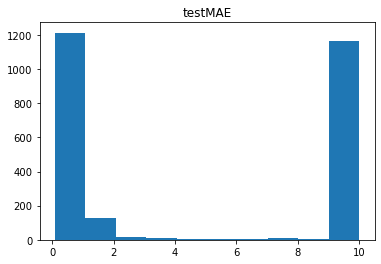

F1: 	 0.8008607198748043

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0, 'learning_rate': 0.0001, 'lstm_units': 32}


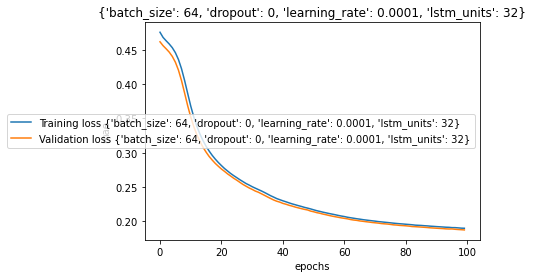

mean_trainMAE: 0.1886068433523178


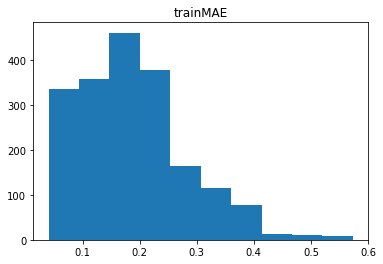

max_trainMAE: 	 0.5735578536987305


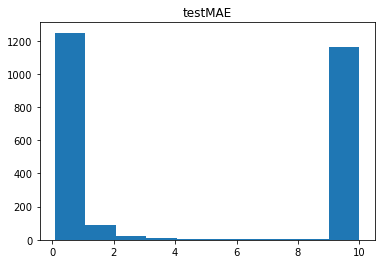

F1: 	 0.823943661971831

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0, 'learning_rate': 0.0001, 'lstm_units': 64}


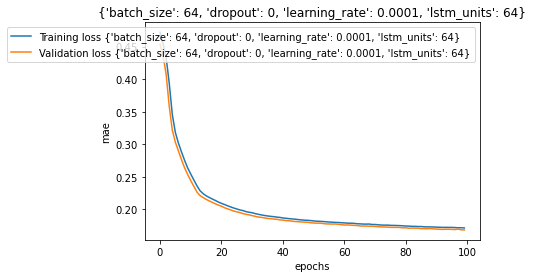

mean_trainMAE: 0.16999949514865875


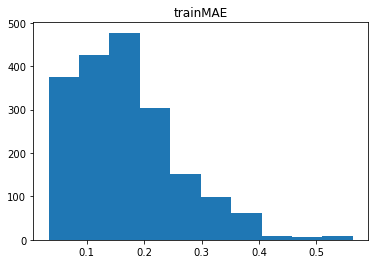

max_trainMAE: 	 0.5634792447090149


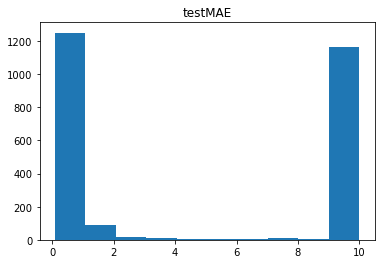

F1: 	 0.8525039123630673

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0, 'learning_rate': 0.001, 'lstm_units': 32}


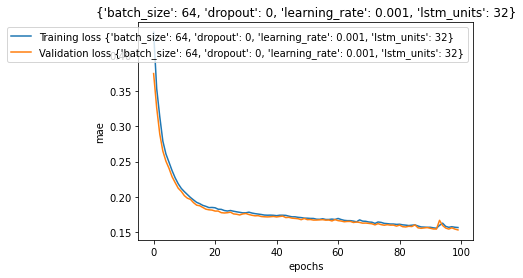

mean_trainMAE: 0.15426822006702423


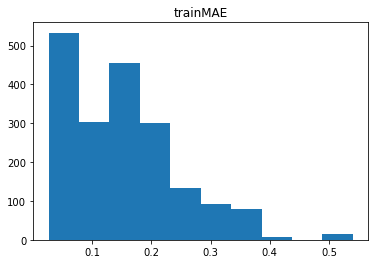

max_trainMAE: 	 0.5399993658065796


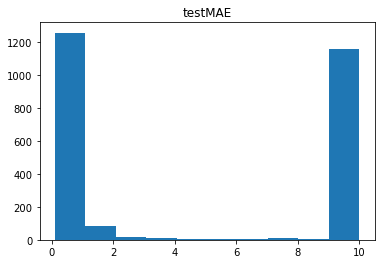

F1: 	 0.8290297339593115

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0, 'learning_rate': 0.001, 'lstm_units': 64}


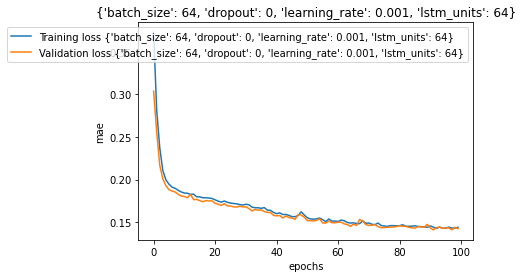

mean_trainMAE: 0.14242641627788544


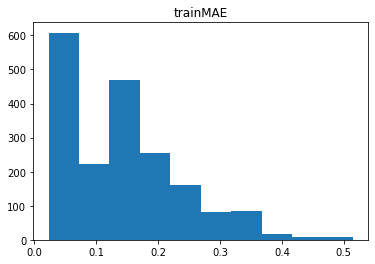

max_trainMAE: 	 0.5147124528884888


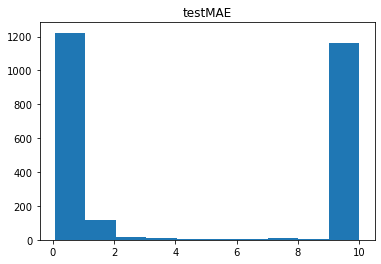

F1: 	 0.8219874804381847

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0, 'learning_rate': 0.01, 'lstm_units': 32}


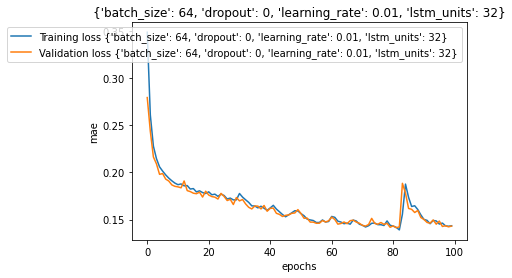

mean_trainMAE: 0.14235694706439972


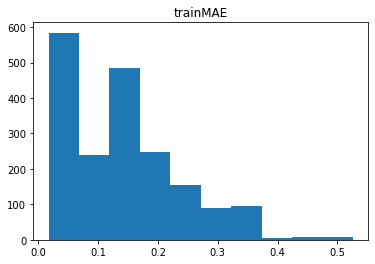

max_trainMAE: 	 0.5261362791061401


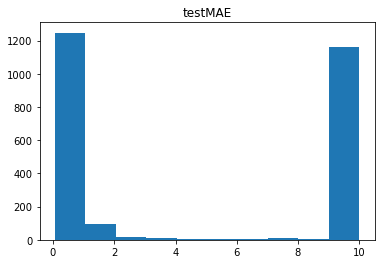

F1: 	 0.8325508607198749

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0, 'learning_rate': 0.01, 'lstm_units': 64}


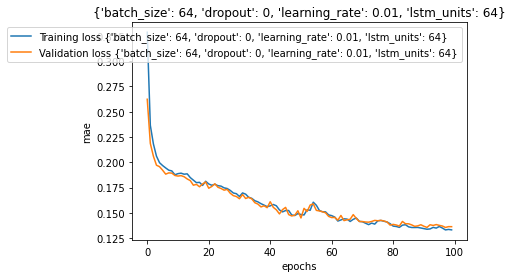

mean_trainMAE: 0.13408303260803223


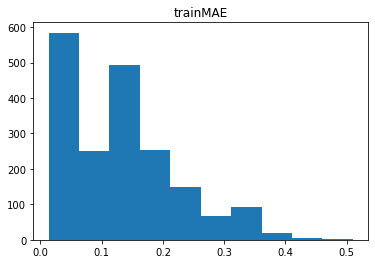

max_trainMAE: 	 0.5103480219841003


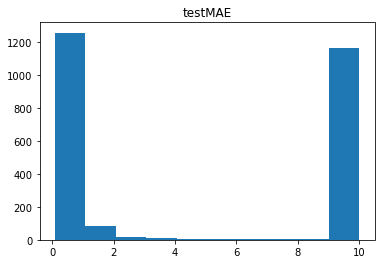

F1: 	 0.8188575899843505

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.1, 'learning_rate': 0.0001, 'lstm_units': 32}


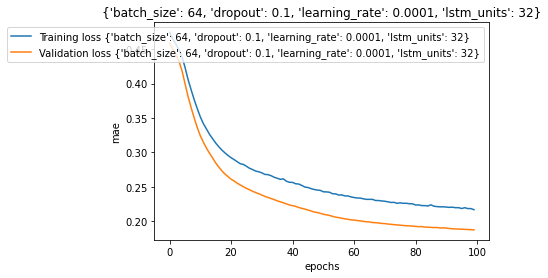

mean_trainMAE: 0.18883085250854492


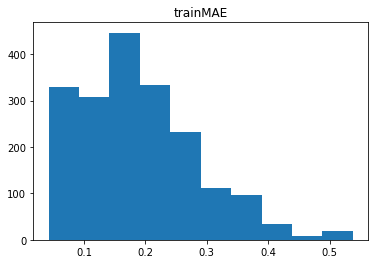

max_trainMAE: 	 0.5377614498138428


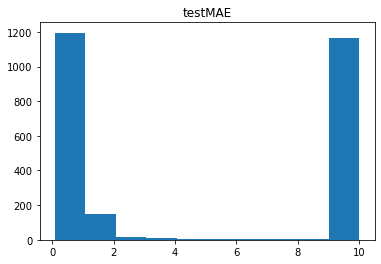

F1: 	 0.8024256651017214

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.1, 'learning_rate': 0.0001, 'lstm_units': 64}


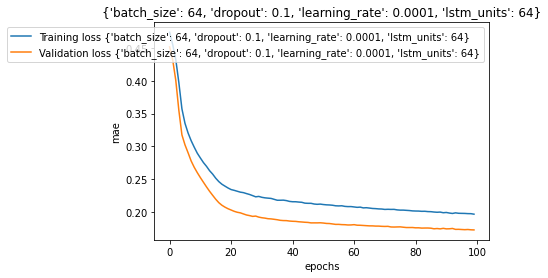

mean_trainMAE: 0.1740971952676773


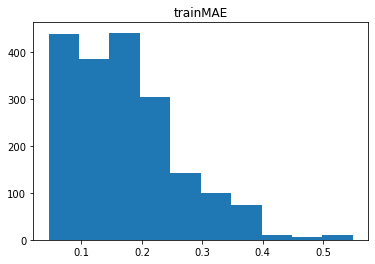

max_trainMAE: 	 0.5489128828048706


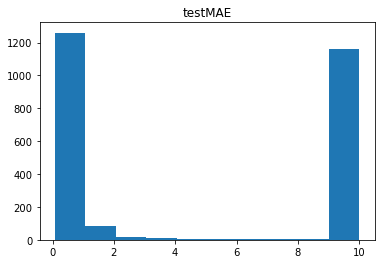

F1: 	 0.8364632237871674

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.1, 'learning_rate': 0.001, 'lstm_units': 32}


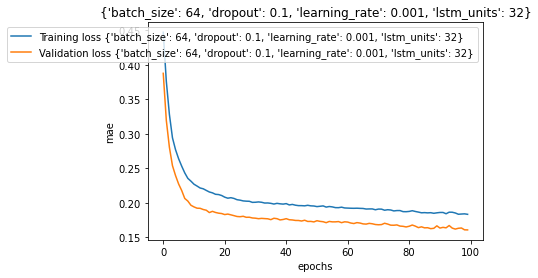

mean_trainMAE: 0.162439227104187


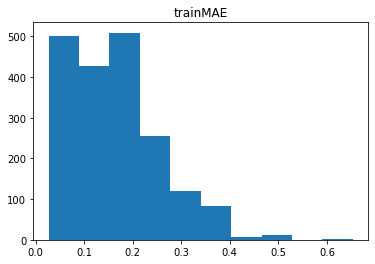

max_trainMAE: 	 0.6534467935562134


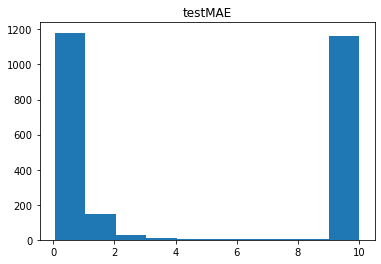

F1: 	 0.852112676056338

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.1, 'learning_rate': 0.001, 'lstm_units': 64}


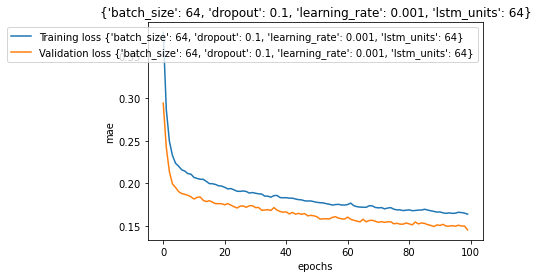

mean_trainMAE: 0.1457945704460144


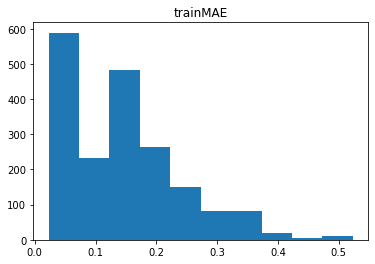

max_trainMAE: 	 0.5234212279319763


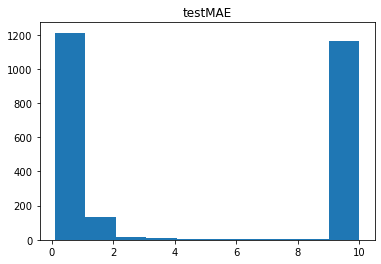

F1: 	 0.8082942097026603

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.1, 'learning_rate': 0.01, 'lstm_units': 32}


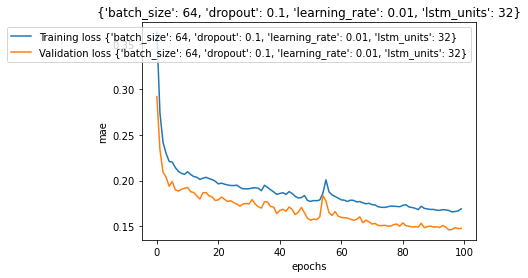

mean_trainMAE: 0.1482151299715042


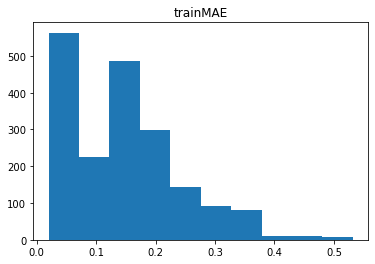

max_trainMAE: 	 0.5320103168487549


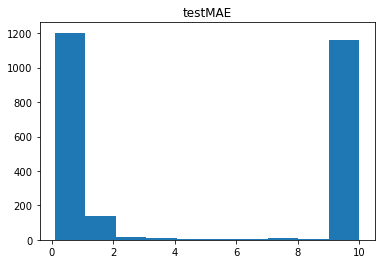

F1: 	 0.8110328638497653

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.1, 'learning_rate': 0.01, 'lstm_units': 64}


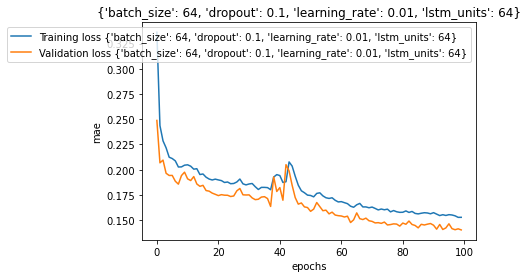

mean_trainMAE: 0.13985762000083923


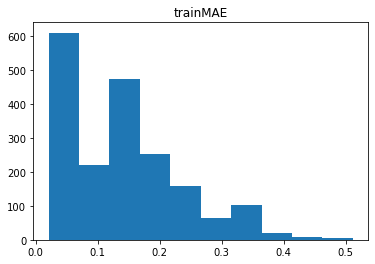

max_trainMAE: 	 0.5119143128395081


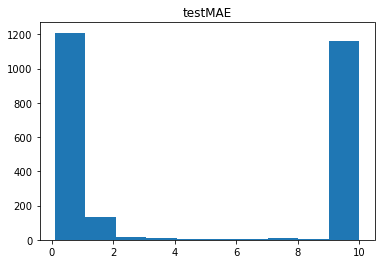

F1: 	 0.7942097026604069

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.0001, 'lstm_units': 32}


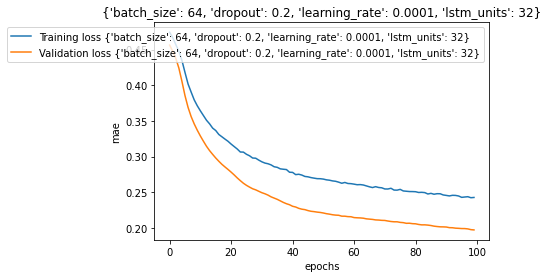

mean_trainMAE: 0.19882875680923462


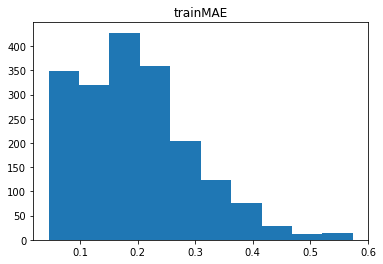

max_trainMAE: 	 0.5737128257751465


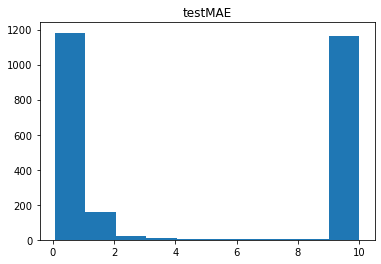

F1: 	 0.8075117370892019

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.0001, 'lstm_units': 64}


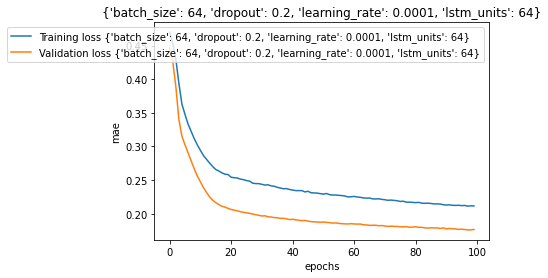

mean_trainMAE: 0.17826226353645325


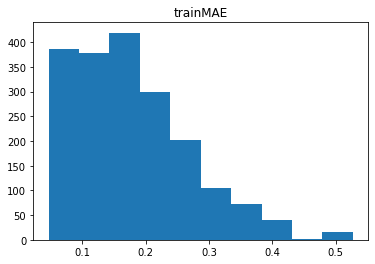

max_trainMAE: 	 0.5273990631103516


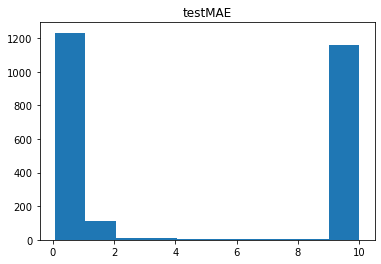

F1: 	 0.8176838810641628

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'lstm_units': 32}


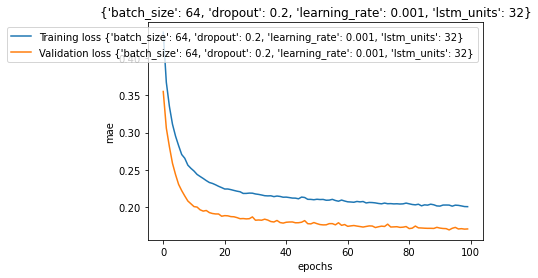

mean_trainMAE: 0.1722031533718109


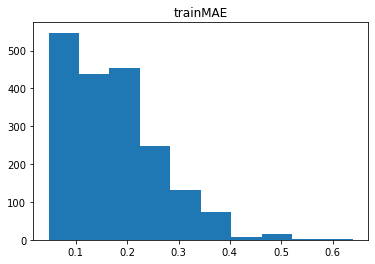

max_trainMAE: 	 0.6397132873535156


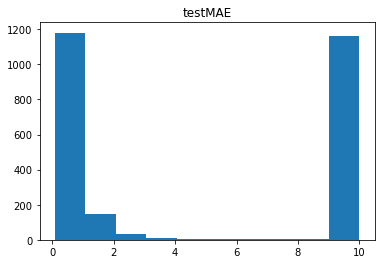

F1: 	 0.8341158059467919

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'lstm_units': 64}


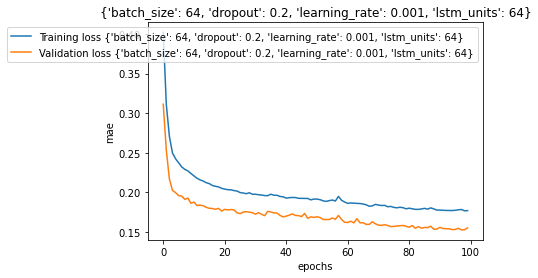

mean_trainMAE: 0.155746728181839


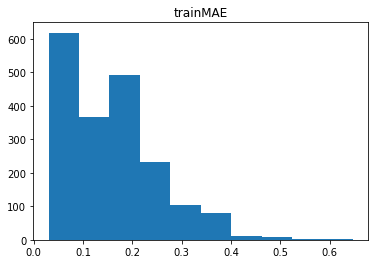

max_trainMAE: 	 0.6472262144088745


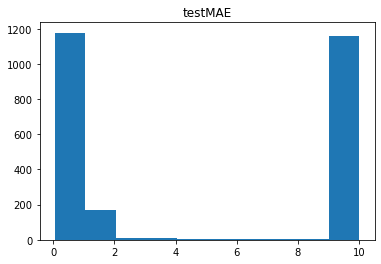

F1: 	 0.8493740219092332

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.01, 'lstm_units': 32}


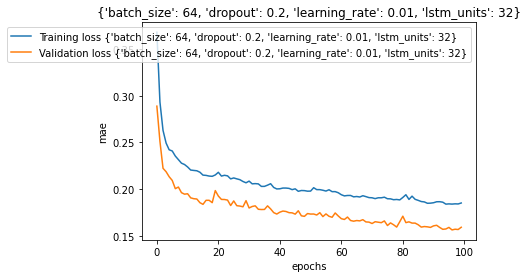

mean_trainMAE: 0.15919451415538788


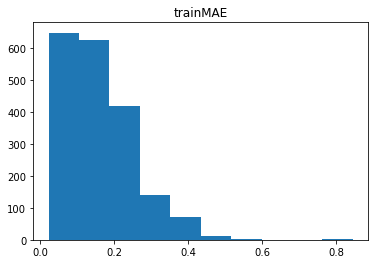

max_trainMAE: 	 0.8452345728874207


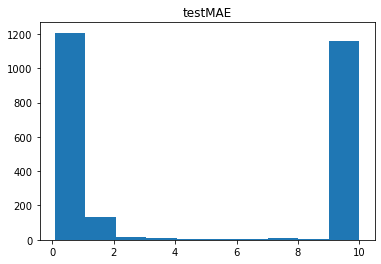

F1: 	 0.8841940532081377

#################################################################

PARÂMETROS: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.01, 'lstm_units': 64}


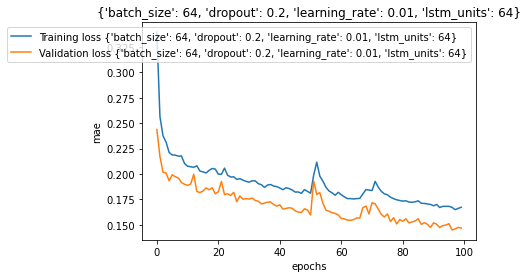

mean_trainMAE: 0.14627034962177277


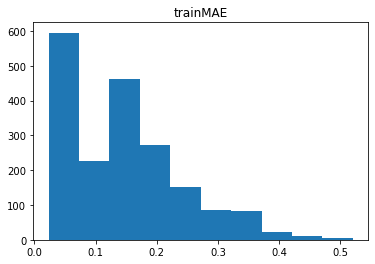

max_trainMAE: 	 0.5205607414245605


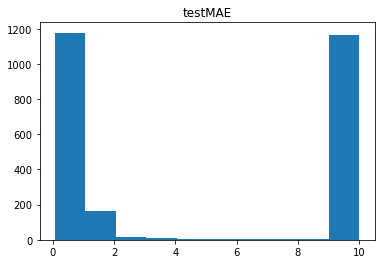

F1: 	 0.8016431924882629

#################################################################



In [6]:
# Aplicação do classificador com combinação de parâmetros

grid_params = {
    'batch_size': [32, 64],
    'lstm_units': [32, 64],
    'dropout': [0, 0.1, 0.2],
    'learning_rate': [0.0001, 0.001, 0.01]
}

scores_autoencoder = pd.DataFrame()

for params in ParameterGrid(grid_params):
    
    print(f'PARÂMETROS: {params}')
    
    # Define o modelo de rede neural
    lstm_encoder = Sequential([
        LSTM(int(params['lstm_units']), return_sequences=True, input_shape=(X_train_simuladas_unificado_50.shape[1], X_train_simuladas_unificado_50.shape[2])),
        Dropout(rate=params['dropout']),
        LSTM(int(params['lstm_units']/2), return_sequences=False),
        Dropout(rate=params['dropout']),
    ], name='encoder')
    lstm_decoder = Sequential([
        RepeatVector(X_train_simuladas_unificado_50.shape[1]),
        LSTM(int(params['lstm_units']/2), return_sequences=True),
        Dropout(rate=params['dropout']),
        LSTM(int(params['lstm_units']), return_sequences=True),
        Dropout(rate=params['dropout']),
        TimeDistributed(Dense(X_train_simuladas_unificado_50.shape[2]))    
    ], name='decoder')
    model = Sequential([lstm_encoder, lstm_decoder])
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mae')
    
    # Treina o modelo
    history = model.fit(X_train_simuladas_unificado_50, X_train_simuladas_unificado_50, epochs=100, batch_size=params['batch_size'], validation_split=0.4, verbose=0)

    # Gráfico de train e validation loss
    fig1, ax1 = plt.subplots()
    ax1.set_title(f'{params}')
    ax1.plot(history.history['loss'], label=f'Training loss {params}')
    ax1.plot(history.history['val_loss'], label=f'Validation loss {params}')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('mae')
    ax1.legend()
    plt.show()

    trainPredict = model.predict(X_train_simuladas_unificado_50)
    trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_simuladas_unificado_50), axis=1), axis=1)
    mean_trainMAE = np.mean(trainMAE)
    print(f'mean_trainMAE: {mean_trainMAE}')
    
    fig2, ax2 = plt.subplots()
    ax2.set_title(f'trainMAE')
    ax2.hist(trainMAE)
    plt.show()
    
    max_trainMAE = np.max(trainMAE)
    print(f'max_trainMAE: \t {max_trainMAE}')

    testPredict = model.predict(X_test_simuladas_unificado_50)
    testMAE = np.mean(np.mean(np.abs(testPredict - X_test_simuladas_unificado_50), axis=1), axis=1)
    
    fig3, ax3 = plt.subplots()
    ax3.set_title(f'testMAE')
    #Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
    testMAE_visualizacao = testMAE
    testMAE_visualizacao[testMAE_visualizacao > 10] = 10
    ax3.hist(testMAE_visualizacao)
    plt.show()
    
    # Será considerada anomalia aquela observação cujo erro de reconstrução seja 
    # acima de um valor especificado como gatilho (usado max_trainMAE)
    y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

    # Calcula as metricas de desempenho
    p, r, f1, _ = precision_recall_fscore_support(y_test_simuladas_unificado_50, y_pred, average='micro')
    
    print(f'F1: \t {f1}')
    
    scores_autoencoder = scores_autoencoder.append({'CLASSIFICADOR': params, 
                                'F1': f1}, ignore_index=True)
    print('\n#################################################################\n')

In [7]:
# Tabela com resultados filtrados F1:
scores_autoencoder_table = scores_autoencoder.sort_values(by=['F1'], ascending=False)
scores_autoencoder_table.to_csv(r'./results/7_anomaly_detection_scores_autoencoder_50%_simuladas.csv')
scores_autoencoder_table

,CLASSIFICADOR,F1
34,"{'batch_size': 64, 'dropout': 0.2, 'learning_r...",0.884194
1,"{'batch_size': 32, 'dropout': 0, 'learning_rat...",0.876761
2,"{'batch_size': 32, 'dropout': 0, 'learning_rat...",0.872066
0,"{'batch_size': 32, 'dropout': 0, 'learning_rat...",0.868545
19,"{'batch_size': 64, 'dropout': 0, 'learning_rat...",0.852504
26,"{'batch_size': 64, 'dropout': 0.1, 'learning_r...",0.852113
33,"{'batch_size': 64, 'dropout': 0.2, 'learning_r...",0.849374
25,"{'batch_size': 64, 'dropout': 0.1, 'learning_r...",0.836463
32,"{'batch_size': 64, 'dropout': 0.2, 'learning_r...",0.834116
22,"{'batch_size': 64, 'dropout': 0, 'learning_rat...",0.832551


### Calibração com LOF nas características reduzidas do autoencoder:

In [8]:
# A melhor configuração de rede neural será utilizada na calibração do LOF:
scores_autoencoder_table["CLASSIFICADOR"][0]

{'batch_size': 32, 'dropout': 0, 'learning_rate': 0.0001, 'lstm_units': 32}

In [9]:
# Resimula a rede neural com melhores parâmetros para obter as features encoded em seguida
lstm_encoder = Sequential([
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']), return_sequences=True, input_shape=(X_train_simuladas_unificado_50.shape[1], X_train_simuladas_unificado_50.shape[2])),
    Dropout(rate=int(scores_autoencoder_table["CLASSIFICADOR"][0]['dropout'])),
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']/2), return_sequences=False),
    Dropout(rate=int(scores_autoencoder_table["CLASSIFICADOR"][0]['dropout'])),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_simuladas_unificado_50.shape[1]),
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']/2), return_sequences=True),
    Dropout(rate=int(scores_autoencoder_table["CLASSIFICADOR"][0]['dropout'])),
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']), return_sequences=True),
    Dropout(rate=int(scores_autoencoder_table["CLASSIFICADOR"][0]['dropout'])),
    TimeDistributed(Dense(X_train_simuladas_unificado_50.shape[2]))    
], name='decoder')
model = Sequential([lstm_encoder, lstm_decoder])
model.compile(optimizer='adam', loss='mae')
history = model.fit(X_train_simuladas_unificado_50, X_train_simuladas_unificado_50, epochs=100, batch_size=scores_autoencoder_table["CLASSIFICADOR"][0]['batch_size'], validation_split=0.4, verbose=0)

In [10]:
# Obtem as encoded features por amostra
encoder = model.get_layer("encoder")
X_train_simuladas_unificado_encoded_50 = encoder.predict(X_train_simuladas_unificado_50)
X_test_simuladas_unificado_encoded_50 = encoder.predict(X_test_simuladas_unificado_50)

# Testa o LOF com diversos parâmetros
from sklearn.neighbors import LocalOutlierFactor

# LOCAL OUTLIER FACTOR (LOF) - busca de melhores hiperparâmetros
clfs = {}
scores_lof = pd.DataFrame()

lof_params = {
    'n_neighbors': [5, 10, 15, 20],
    'algorithm': ['auto'],
    'metric': ['hamming', 'euclidean', 'manhattan' , 'minkowski'],
    'contamination': ['auto', 0.01, 0.05, 0.10],
    'novelty': [True]
}    
for params in ParameterGrid(lof_params):
    lof_clf = LocalOutlierFactor().set_params(**params)
    clfs[f'Local Outlier Factor (LOF): {params}'] = lof_clf
    
for clf_name, clf in clfs.items():
    clf.fit(X_train_simuladas_unificado_encoded_50)
    y_pred = clf.predict(X_test_simuladas_unificado_encoded_50)
    p, r, f1, _ = precision_recall_fscore_support(y_test_simuladas_unificado_50, y_pred, average='micro')
    scores_lof = scores_lof.append({'CLASSIFICADOR': clf_name, 
                            'F1': f1}, ignore_index=True)

In [11]:
# Dados de F1 LOF ordenados
score_lof_table = scores_lof.sort_values(by=['F1'], ascending=False)
score_lof_table.to_csv(r'./results/7_anomaly_detection_scores_lof_50%_simuladas.csv')
score_lof_table

,CLASSIFICADOR,F1
27,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.709311
23,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.706573
31,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.706573
43,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.698357
26,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.693271
...,...,...
40,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.476135
36,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.471049
44,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.471049
21,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.455790


In [12]:
# A melhor configuração para o LOF:
score_lof_table["CLASSIFICADOR"][0]

"Local Outlier Factor (LOF): {'algorithm': 'auto', 'contamination': 'auto', 'metric': 'hamming', 'n_neighbors': 5, 'novelty': True}"

In [19]:
# Calcular tempo total do notebook Jupyter
print(f'Tempo total de execução (hh:mm:ss.ms): {datetime.now() - start_time}')

Tempo total de execução (hh:mm:ss.ms): 1 day, 11:28:48.525860
